# PROJECT SECTIONS
- Dataset & Preprocessing
  - Fetching & Comparing Artist Genres w/ Spotify API
  - Moving/Dropping Columns
  - Scale Features
- Principle Component Analysis (PCA)
  - Apply on Features
  - Researching a More Optimal Feature Set
- Evalution Metrics
  - Elbow-Method (Experimenting w/ k value)
  - Silhouette Score ...
- KMeans
  - Fitting the Model
  - Light Feature Engineering (Cluster #, Dist to Centroid)
  - Cluster Subset & Filtering Output

In [ ]:
# importing dependencies
from datasets import load_dataset
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import requests

## Dataset & Preprocessing

In [2]:
# loading from huggingface
# dataset_hf = load_dataset("maharshipandya/spotify-tracks-dataset")
# dataset = pd.DataFrame(dataset_hf['train'])   #convert dataset to pandas dataframe

#loading from local csv
dataset = pd.read_csv('spotify-tracks-dataset.csv')

# copy the dataset (for reference of original attributes)
data = dataset.copy()

# get genres from the dataset
genres = data['track_genre'].unique()
genres

# format genres to be searchable by keywords
genres_searchable = []
for genre in genres:
    if '-' in genre:    # format hyphenated genres into lists of strings
        genres_searchable.append(genre.split('-'))
    else:
        genres_searchable.append([genre])
genres_searchable
        


[['acoustic'],
 ['afrobeat'],
 ['alt', 'rock'],
 ['alternative'],
 ['ambient'],
 ['anime'],
 ['black', 'metal'],
 ['bluegrass'],
 ['blues'],
 ['brazil'],
 ['breakbeat'],
 ['british'],
 ['cantopop'],
 ['chicago', 'house'],
 ['children'],
 ['chill'],
 ['classical'],
 ['club'],
 ['comedy'],
 ['country'],
 ['dance'],
 ['dancehall'],
 ['death', 'metal'],
 ['deep', 'house'],
 ['detroit', 'techno'],
 ['disco'],
 ['disney'],
 ['drum', 'and', 'bass'],
 ['dub'],
 ['dubstep'],
 ['edm'],
 ['electro'],
 ['electronic'],
 ['emo'],
 ['folk'],
 ['forro'],
 ['french'],
 ['funk'],
 ['garage'],
 ['german'],
 ['gospel'],
 ['goth'],
 ['grindcore'],
 ['groove'],
 ['grunge'],
 ['guitar'],
 ['happy'],
 ['hard', 'rock'],
 ['hardcore'],
 ['hardstyle'],
 ['heavy', 'metal'],
 ['hip', 'hop'],
 ['honky', 'tonk'],
 ['house'],
 ['idm'],
 ['indian'],
 ['indie', 'pop'],
 ['indie'],
 ['industrial'],
 ['iranian'],
 ['j', 'dance'],
 ['j', 'idol'],
 ['j', 'pop'],
 ['j', 'rock'],
 ['jazz'],
 ['k', 'pop'],
 ['kids'],
 ['latin

#### Authenticating to Spotify

In [5]:
from dotenv import load_dotenv
import os
import requests
import json

# Load environment variables
load_dotenv()
client_id = os.getenv('SPOTIFY_CLIENT_ID')
client_secret = os.getenv('SPOTIFY_CLIENT_SECRET')

if not client_id or not client_secret:
    raise ValueError("SPOTIFY_CLIENT_ID or SPOTIFY_CLIENT_SECRET not set in .env file")

# Request token from Spotify API
url = "https://accounts.spotify.com/api/token"
try:
    # Send POST request for token
    auth_response = requests.post(
        url,
        headers={"Content-Type": "application/x-www-form-urlencoded"},
        data={"grant_type": "client_credentials"},
        auth=(client_id, client_secret),
    )

    # Check if the response is successful
    if auth_response.status_code == 200:
        token_data = auth_response.json()
        
        # Save token to JSON file
        with open("token.json", "w") as file:
            json.dump(token_data, file)
        print("Token successfully fetched and saved.")
    else:
        print("Error fetching token:", auth_response.status_code, auth_response.text)
        exit()

except requests.exceptions.RequestException as e:
    print("Error during token request:", str(e))
    exit()

# Load token from JSON and validate
try:
    with open('token.json', 'r') as file:
        token_data = json.load(file)
        token = token_data.get('access_token')
        token_type = token_data.get('token_type')

        if not token or not token_type:
            raise ValueError("Access token or token type not found in the response")

        # Validation successful, do not print sensitive details
        print("Token loaded successfully and ready for use.")

except FileNotFoundError:
    print("Error: token.json file not found")
except ValueError as e:
    print("Error parsing token:", str(e))
except json.JSONDecodeError:
    print("Error decoding JSON file")



Token successfully fetched and saved.
Token loaded successfully and ready for use.


#### Define Track/Song (via API)

In [4]:
# test track audio features
track_id = '3SktMqZmo3M9zbB7oKMIF7'
aud_features_url = "https://api.spotify.com/v1/audio-features/"

aud_features_json = requests.get(aud_features_url + track_id, headers={'Authorization': f'{token_type} {token}'}).json()

In [5]:
# test get track
track_url = "https://api.spotify.com/v1/tracks/"

# get track json data
track_json = requests.get(track_url + track_id, headers={'Authorization': f'{token_type} {token}'}).json()

# extract track artists and name
track_artists_list = [artist['name'] for artist in track_json['artists']]
track_artists_str = ', '.join(track_artists_list)
track_name = track_json['name']
artist_id = track_json['artists'][0]['id']
track_name, track_artists_str

('Gravity', 'John Mayer')

#### Fetch Track Artist's Genres

In [6]:
# TODO: See if genres_searchable is preventing matches 
# TODO: Ensure multi-artist tracks include all genres

artist_url = "https://api.spotify.com/v1/artists/"

# get album json data
artist_json = requests.get(artist_url + artist_id, headers={'Authorization': f'{token_type} {token}'}).json()
artist_genres = artist_json['genres']

# separate words in artist genres
artist_genres_words = [genre.split() for genre in artist_genres]

# flatten list
artist_genres_words = list(set([word for genre in artist_genres_words for word in genre]))
print(f"artist_genres_words: {artist_genres_words}") # TODO: fix

# print genres that are in the dataset
genre_response = 'GENRES IN DATASET & ASSOCIATED W/ TRACK ARTIST: '
for word in artist_genres_words:
    if word in genres:
        genre_response += '\n' + word
print(genre_response)

artist_genres_words: ['mellow', 'singer-songwriter', 'neo']
GENRES IN DATASET & ASSOCIATED W/ TRACK ARTIST: 
singer-songwriter


#### Drop & Move Columns

In [7]:
# unnecessary columns TODO: Check Train Dataset for Columns or Features
# Filter only columns that exist in the DataFrame
cols_to_drop = ['Unnamed: 0', 'album_name', 'loudness', 'explicit', 
                'time_signature', 'instrumentalness', 'duration_ms', 
                'mode', 'valence']

# Drop only existing columns
existing_cols_to_drop = [col for col in cols_to_drop if col in dataset.columns]
dataset.drop(existing_cols_to_drop, axis=1, inplace=True)

# Drop duplicates (tracks with the same track_id)
dataset.drop_duplicates(subset='track_id', keep='first', inplace=True)
dataset.drop_duplicates(subset='track_name', keep='first', inplace=True)

# Reorder columns based on position_map
position_map = {
    "track_name": 0,
    "artists": 1,
    "track_genre": 2,
    "track_id": 3
}

for attribute, position in position_map.items():
    if attribute in dataset.columns:  # Ensure column exists before reordering
        col_data = dataset.pop(attribute)
        dataset.insert(position, attribute, col_data)

# Print first 5 rows
print(dataset.head())

                   track_name                 artists track_genre  \
0                      Comedy             Gen Hoshino    acoustic   
1            Ghost - Acoustic            Ben Woodward    acoustic   
2              To Begin Again  Ingrid Michaelson;ZAYN    acoustic   
3  Can't Help Falling In Love            Kina Grannis    acoustic   
4                     Hold On        Chord Overstreet    acoustic   

                 track_id  popularity  danceability  energy  key  speechiness  \
0  5SuOikwiRyPMVoIQDJUgSV          73         0.676  0.4610    1       0.1430   
1  4qPNDBW1i3p13qLCt0Ki3A          55         0.420  0.1660    1       0.0763   
2  1iJBSr7s7jYXzM8EGcbK5b          57         0.438  0.3590    0       0.0557   
3  6lfxq3CG4xtTiEg7opyCyx          71         0.266  0.0596    0       0.0363   
4  5vjLSffimiIP26QG5WcN2K          82         0.618  0.4430    2       0.0526   

   acousticness  liveness    tempo  
0        0.0322    0.3580   87.917  
1        0.9240    0.101

## Principle Component Analysis (PCA)

#### Feature Scaling

In [8]:
from sklearn.preprocessing import StandardScaler

# Select numeric columns to scale (excluding the first few or categorical columns)
numeric_columns = dataset.columns[4:]  # Replace with explicit names if possible

# Ensure columns are numeric
dataset[numeric_columns] = dataset[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Feature scale the selected columns
scaler = StandardScaler()
dataset[numeric_columns] = scaler.fit_transform(dataset[numeric_columns])


#### Applying PCA

In [10]:
from sklearn.decomposition import PCA

# Create a PCA instance with 2 components
pca_2d = PCA(n_components=2)

# Apply PCA to the scaled numeric data
pca_transformed_data_2d = pca_2d.fit_transform(scaled_data)

# Analyze the reduced data
print(f"Explained variance ratio: {pca_2d.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca_2d.explained_variance_ratio_)}")

# Convert to a DataFrame
pca_2d_df = pd.DataFrame(pca_transformed_data_2d, columns=['PC1', 'PC2'])
print(pca_2d_df.head())  # Preview the reduced dataset


Explained variance ratio: [0.24219015 0.15994363]
Total variance explained: 0.4021337835919608
        PC1       PC2
0 -0.032073 -0.087487
1 -3.074955 -0.140430
2 -1.307525 -0.557566
3 -2.398794 -0.687796
4 -0.875123 -1.416178


## Evalution Metrics

#### Elbow Method

In [11]:
X_pca = pca_transformed_data_2d

# Perform clustering for a range of cluster numbers
inertia = []  # To store the sum of squared distances (inertia)
K = range(1, 11)  # Number of clusters to try

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

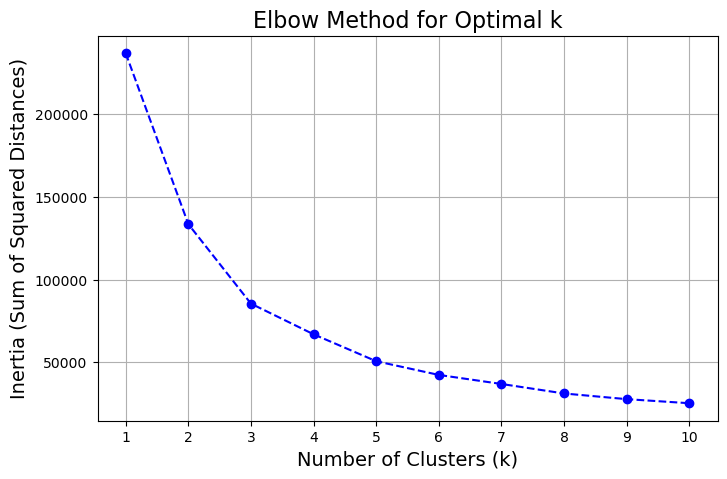

In [12]:
# Plotting Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Inertia (Sum of Squared Distances)', fontsize=14)
plt.title('Elbow Method for Optimal k', fontsize=16)
plt.xticks(K)
plt.grid(True)
plt.show()

##### Elbow at 3 clusters I think?

#### Silhouette Score

In [14]:
from sklearn.utils import resample

# Reduce the size of the dataset for silhouette computation
sampled_X_pca = resample(X_pca, n_samples=5000, random_state=42)  # Adjust n_samples as needed

# Recalculate silhouette scores with sampled data
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(sampled_X_pca)
    score = silhouette_score(sampled_X_pca, labels)
    silhouette_scores.append(score)


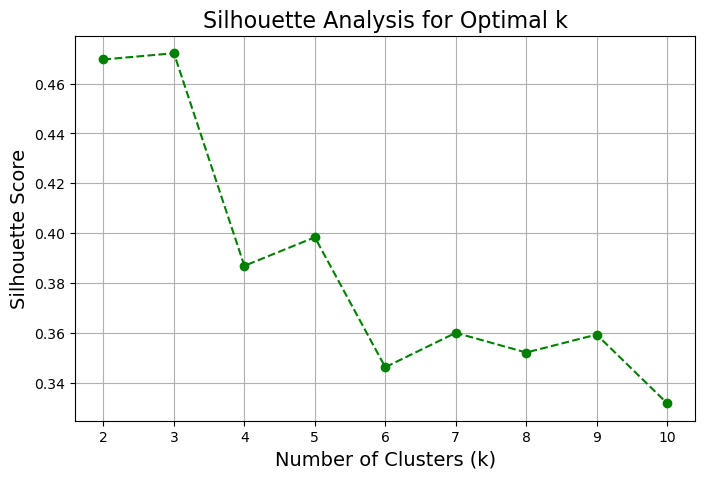

In [17]:
# Step 3: Plot silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--', color='g')
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Silhouette Score', fontsize=14)
plt.title('Silhouette Analysis for Optimal k', fontsize=16)
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()


#### TODO (Optional): Davies Bouldin Index

## KMeans

## Sort Dataset by Cluster & Distance-to-Cluster


In [ ]:
# add a column to the dataset for the cluster number and distance from the centroid
dataset['cluster'] = pred_y
dataset['distance'] = kmeans.fit_transform(data_pca).min(axis=1)

# sort the dataset by cluster and distance
dataset = dataset.sort_values(by=['cluster', 'distance'])

# print the first 10 rows
dataset.head(10)


# Song Recommendations

In [ ]:
# search for song's full data using the track_id
song_matches = dataset[dataset['track_id'] == track_id]

# get the first occurrence
full_given_song = song_matches.loc[song_matches.first_valid_index()]

# save the numerical data in a separate variable
given_song = full_given_song[4:].astype(float)

# print the full given song data
print(f"DATA FROM: {track_name} by {track_artists_str}")
given_song

## Initial Cluster Points & Filtering

In [ ]:
# find the closest centroid

# get the index of the closest centroid
closest_centroid_idx = int(given_song['cluster'])

# get the coordinates of the closest centroid
closest_centroid = kmeans.cluster_centers_[closest_centroid_idx]

# Find data points belonging to the closest cluster
cluster_points = dataset.iloc[:, :][kmeans.labels_ == closest_centroid_idx]

# Remove the given song from the closest cluster if it exists
cluster_points = cluster_points[cluster_points['track_name'] != full_given_song['track_name']]

# Only consider songs of the same genre
# TODO: create clusters of genres that are similar and only from the that cluster
cluster_points = cluster_points[cluster_points['track_genre'] == full_given_song['track_genre']]

# print the amount of songs filtered
print(cluster_points.shape)

cluster_points.head(10)